## Bakersfield PM2.5 Prediction
 This notebook focuses on obtaining the best subset of the database for Bakersfield city in California to train a model for predicting PM2.5 concentration in the air.<br>
 
<img src="images/reference.png" alt="" style="width:450px;"> 
<img src="images/city.png" alt="" style="width:450px;">

## Merge the Data

In [80]:
import pandas as pd

dfs = {}

for i in range(1999, 2025):
    dfs[f"df{i-1998}"] = pd.read_csv(f"data_raw/pm25_{i}.csv")

data = pd.concat(dfs.values(), ignore_index=True, verify_integrity=True)

data.to_csv('data_mod/data_merge.csv', index=False) 



## Check the Data

All the data in Bakersfield

In [81]:
all((data['CBSA_NAME'].unique())=='Bakersfield, CA')

True

Split Bakersfield sites

In [83]:
equal = data['Site Name'].nunique() == data['Site ID'].nunique()

if equal:
    print("IDs=Sites Names.")
else:
    print("IDs!=Sites Names.")


for i, (site_id, group) in enumerate(data.groupby('Site ID'), start=1):
    filename = f"data_mod/id_{i}.csv"
    group.to_csv(filename, index=False)


IDs=Sites Names.


The site with the most data on Bakersfield

In [84]:
num_rows_per_id = []

for site_id in range(1, 13):
    filename = f"data_mod/id_{site_id}.csv"
    df = pd.read_csv(filename)
    
    num_rows = len(df)
    num_rows_per_id.append(num_rows)

    print(f"The DataFrame for 'Site ID' {site_id} has {num_rows} rows.")


The DataFrame for 'Site ID' 1 has 3705 rows.
The DataFrame for 'Site ID' 2 has 4240 rows.
The DataFrame for 'Site ID' 3 has 23321 rows.
The DataFrame for 'Site ID' 4 has 1190 rows.
The DataFrame for 'Site ID' 5 has 2636 rows.
The DataFrame for 'Site ID' 6 has 2114 rows.
The DataFrame for 'Site ID' 7 has 854 rows.
The DataFrame for 'Site ID' 8 has 312 rows.
The DataFrame for 'Site ID' 9 has 61 rows.
The DataFrame for 'Site ID' 10 has 4710 rows.
The DataFrame for 'Site ID' 11 has 1917 rows.
The DataFrame for 'Site ID' 12 has 476 rows.


Check duplitcates

In [118]:
import pandas as pd

# Load the DataFrame from the CSV file
data = pd.read_csv("data_mod/id_3.csv")

data_original = data.copy()

data_unique = data.drop_duplicates()

print(f'DataFrame original shape: {data_original.shape}')
print(f'data unique shape: {data_unique.shape}')

DataFrame original shape: (23321, 20)
data unique shape: (23321, 20)


## PCA

Text(0, 0.5, 'pm25')

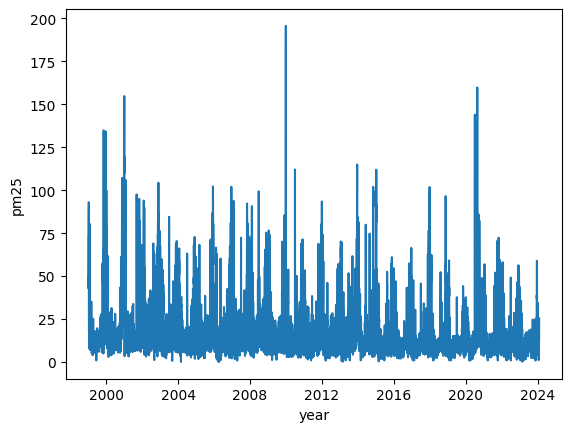

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("data_mod/id_3.csv")
data.loc[:, 'Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')

data_mod = data[[column for column in data.columns if column in ['Date', 'Daily Mean PM2.5 Concentration']]].copy()

data_mod.rename(columns={'Daily Mean PM2.5 Concentration': 'pm25', 'Date': 'day'}, inplace=True)
data_mod.sort_values(by='day', inplace=True)
plt.plot(data_mod['day'], data_mod['pm25'])
plt.xlabel('year')
plt.ylabel('pm25')



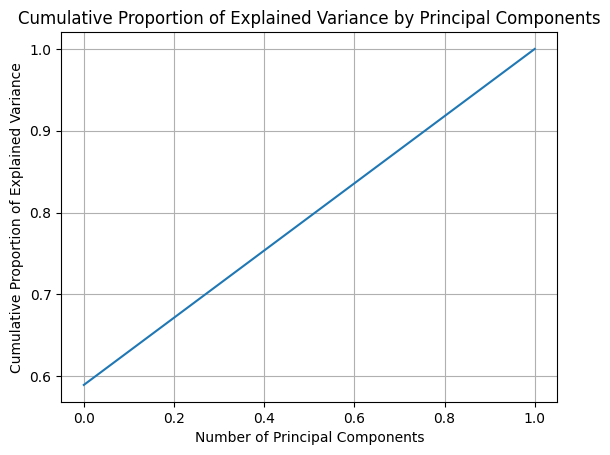

[0.58937661 0.41062339]
Temporal cutoff interval: 0.9999999999999969


In [13]:
from sklearn.decomposition import PCA

# Convert the date to Unix timestamps

data_mod['day'] = pd.to_datetime(data_mod['day'])

data_mod['numerical_date'] = (data_mod['day'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Normalize the numerical columns
numeric_columns = ['numerical_date', 'pm25']
data_mod_numeric = data_mod[numeric_columns]
data_mod_normalized = (data_mod_numeric - data_mod_numeric.mean()) / data_mod_numeric.std()


pca = PCA()
pca.fit(data_mod_normalized)

# Plot
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.title('Cumulative Proportion of Explained Variance by Principal Components')
plt.grid(True)
plt.show()
# Apply PCA
pca = PCA(n_components=2) 

principal_components = pca.fit_transform(data_mod_normalized)

print(pca.explained_variance_ratio_)  # Variance explained by each principal component

component_weights = pca.components_[1]  
temporal_cutoff = component_weights[1] / component_weights[0]  

print("Temporal cutoff interval:", temporal_cutoff)